# Malicous Domain Dataset Preprocessing

In [25]:
import pandas as pd

datasource = "dataset.csv"
data = pd.read_csv(datasource)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Domain               90000 non-null  int64  
 1   DNSRecordType        90000 non-null  object 
 2   MXDnsResponse        90000 non-null  bool   
 3   TXTDnsResponse       90000 non-null  bool   
 4   HasSPFInfo           90000 non-null  bool   
 5   HasDkimInfo          90000 non-null  bool   
 6   HasDmarcInfo         90000 non-null  bool   
 7   Ip                   90000 non-null  int64  
 8   DomainInAlexaDB      90000 non-null  bool   
 9   CommonPorts          90000 non-null  bool   
 10  CountryCode          60948 non-null  object 
 11  RegisteredCountry    12226 non-null  object 
 12  CreationDate         90000 non-null  int64  
 13  LastUpdateDate       90000 non-null  int64  
 14  ASN                  90000 non-null  int64  
 15  HttpResponseCode     90000 non-null 

In [26]:
data.describe()

,Domain,Ip,CreationDate,LastUpdateDate,ASN,HttpResponseCode,SubdomainNumber,Entropy,EntropyOfSubDomains,StrangeCharacters,ConsoantRatio,NumericRatio,SpecialCharRatio,VowelRatio,ConsoantSequence,VowelSequence,NumericSequence,SpecialCharSequence,DomainLength,Class
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,44999.500000,13479.648033,1.933611,2.365744,23335.808167,0.667033,103.069200,2.866844,0.003178,3.498011,0.459519,0.144281,0.006526,0.261528,2.719222,1.342756,1.516478,0.112378,26.440422,0.500000
std,25980.906451,4160.266410,1.997232,1.935509,37004.865724,1.203285,4243.802846,0.488291,0.081042,4.471591,0.146031,0.147331,0.026162,0.098600,1.699339,0.554527,1.538932,0.431967,22.341135,0.500003
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,22499.750000,11709.750000,0.000000,0.000000,-1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.200000,2.000000,1.000000,0.000000,0.000000,15.000000,0.000000
50%,44999.500000,14626.000000,0.000000,4.000000,26228.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.500000,0.100000,0.000000,0.200000,2.000000,1.000000,1.000000,0.000000,24.000000,0.500000
75%,67499.250000,16984.000000,4.000000,4.000000,26228.000000,2.000000,57.000000,3.000000,0.000000,7.000000,0.600000,0.300000,0.000000,0.300000,3.000000,2.000000,3.000000,0.000000,31.000000,1.000000
max,89999.000000,16984.000000,4.000000,4.000000,398108.000000,5.000000,661909.000000,5.000000,3.000000,124.000000,1.000000,0.800000,0.900000,0.800000,37.000000,7.000000,45.000000,61.000000,153.000000,1.000000


<AxesSubplot:title={'center':'Domain Length'}, ylabel='Frequency'>

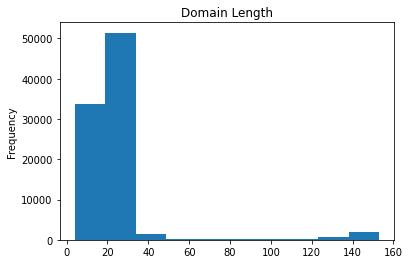

In [54]:
data.DomainLength.plot(kind="hist", title="Domain Length")

<AxesSubplot:title={'center':'Top 10 Country Codes'}>

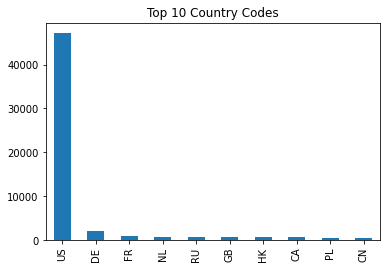

In [55]:
data.CountryCode.value_counts().head(10).plot.bar(title="Top 10 Country Codes")

In [66]:
data.groupby(["HasSPFInfo", "Class"]).agg({"Class": "count"})

Class
HasSPFInfo Class       
False      0      35218
           1      10561
True       0       9782
           1      34439

In [67]:
data.groupby(["HasDkimInfo", "Class"]).agg({"Class": "count"})

Class
HasDkimInfo Class       
False       0      44981
            1      44997
True        0         19
            1          3

In [68]:
data.groupby(["HasDmarcInfo", "Class"]).agg({"Class": "count"})

Class
HasDmarcInfo Class       
False        0      43755
             1      44454
True         0       1245
             1        546

In [82]:
data.groupby(["DomainReputation", "Class"]).agg({"Class": "count"})

Class
DomainReputation Class       
False            0      44950
                 1      44942
True             0         50
                 1         58

In [71]:
data.groupby(["CommonPorts", "Class"]).agg({"Class": "count"})

Class
CommonPorts Class       
False       0      36815
            1      41335
True        0       8185
            1       3665